# CDS522 Text and Speech Analytics
## Assignment 2 - A Comparison Between LSTM and RNN on Speech Recognition Using TensorFlow
| Name | Matrix No. |
| ---| --- |
| Gan Zhong Li | P-COM0156/21 |
| Tang Eva | P-COM0179/21 |

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

from sklearn.metrics import classification_report

## Import the mini Speech Commands dataset

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Loading the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second. 

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, `tf.squeeze` function is used to drop the extra axis:

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Using `Dataset.shard` function to split the validation set into two halves. 

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [10]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

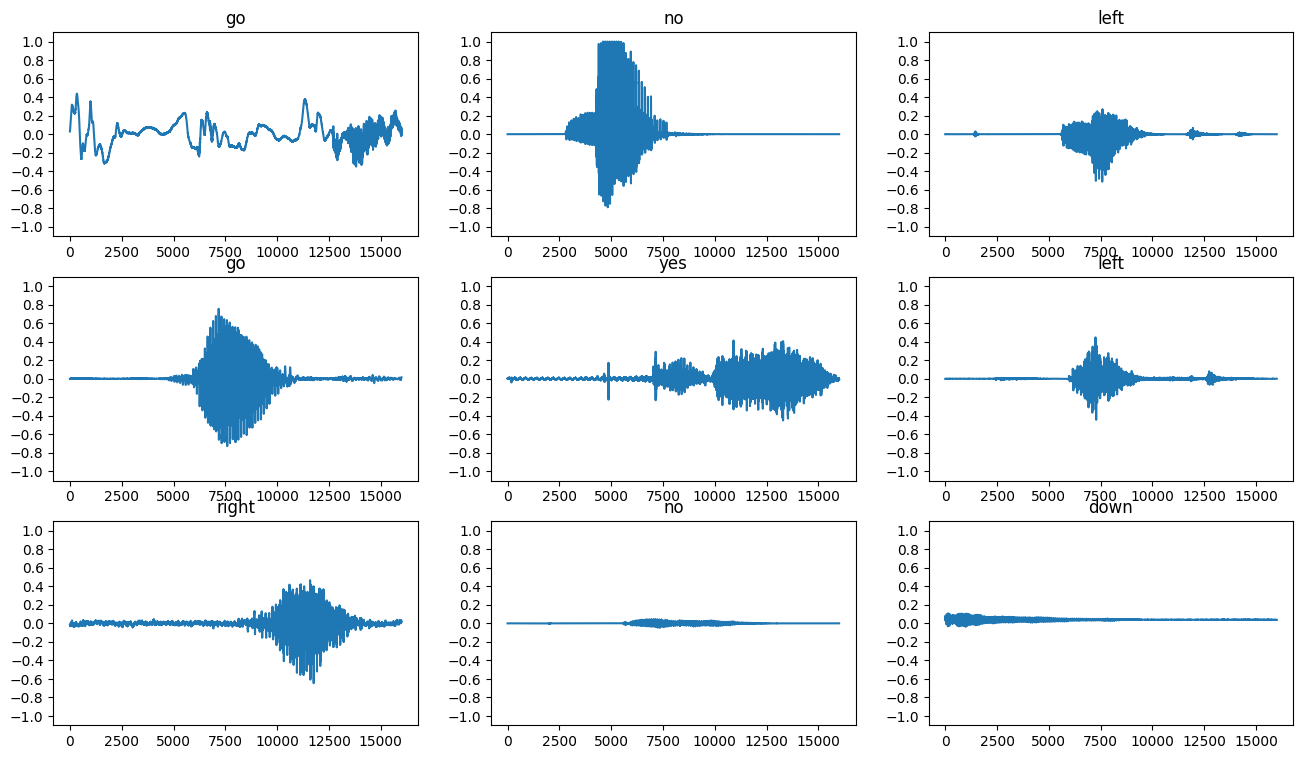

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## Convert waveforms to spectrograms using MFCC

A function is created to transform waveforms to MFCC spectrograms using `tf.signal.linear_to_mel_weight_matrix` and `tf.signal.mfccs_from_log_mel_spectograms`. 

In [12]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  stfts = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(stfts)
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 129
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrograms = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  # Compute MFCCs from log_mel_spectrograms and take the first 13. 
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :]
  return mfccs

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Plotting the spectogram spectrogram:

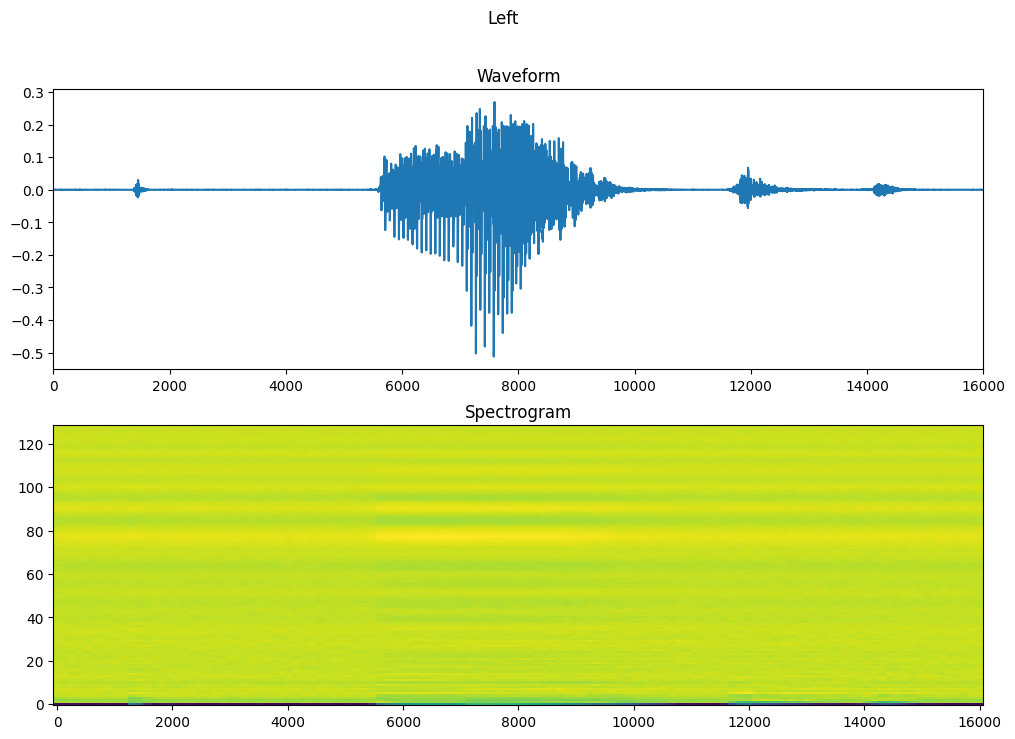

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  spec_t = spectrogram.T
  height = spec_t.shape[0]
  width = spec_t.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, spec_t)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

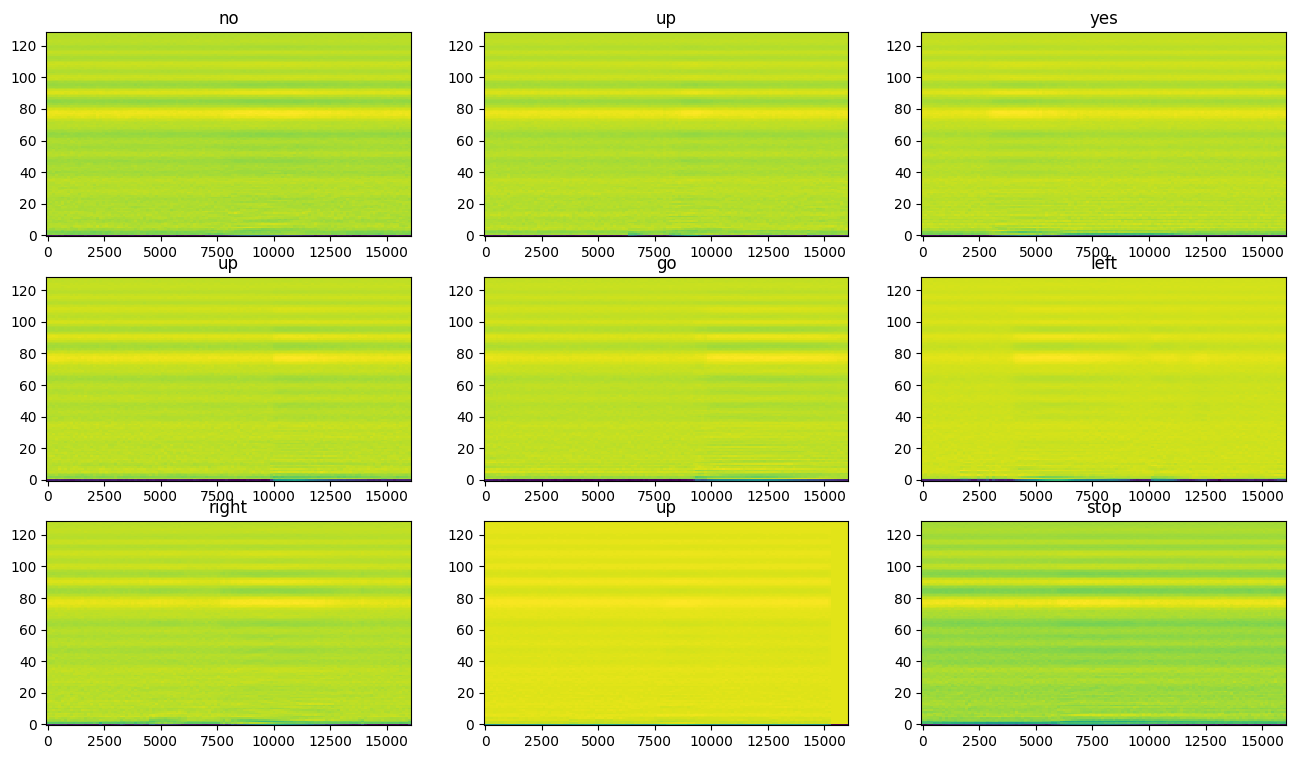

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [18]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### LSTM Model

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    norm_layer,
    layers.LSTM(128, input_shape=input_shape),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 124, 129)         259       
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               132096    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [21]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/100
100/100 [==============================] - 35s 323ms/step - loss: 2.0442 - accuracy: 0.1572 - val_loss: 1.9327 - val_accuracy: 0.2109
Epoch 2/100
100/100 [==============================] - 20s 196ms/step - loss: 1.8592 - accuracy: 0.2206 - val_loss: 1.7544 - val_accuracy: 0.2305
Epoch 3/100
100/100 [==============================] - 18s 178ms/step - loss: 1.7426 - accuracy: 0.2506 - val_loss: 1.7197 - val_accuracy: 0.3307
Epoch 4/100
100/100 [==============================] - 19s 194ms/step - loss: 1.5851 - accuracy: 0.3453 - val_loss: 1.5138 - val_accuracy: 0.4115
Epoch 5/100
100/100 [==============================] - 20s 203ms/step - loss: 1.5112 - accuracy: 0.3920 - val_loss: 1.4471 - val_accuracy: 0.4271
Epoch 6/100
100/100 [==============================] - 21s 213ms/step - loss: 1.3096 - accuracy: 0.4577 - val_loss: 1.2189 - val_accuracy: 0.4909
Epoch 7/100
100/100 [==============================] - 20s 203ms/step - loss: 1.1754 - accuracy: 0.5067 - val_loss: 1.1114 -

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

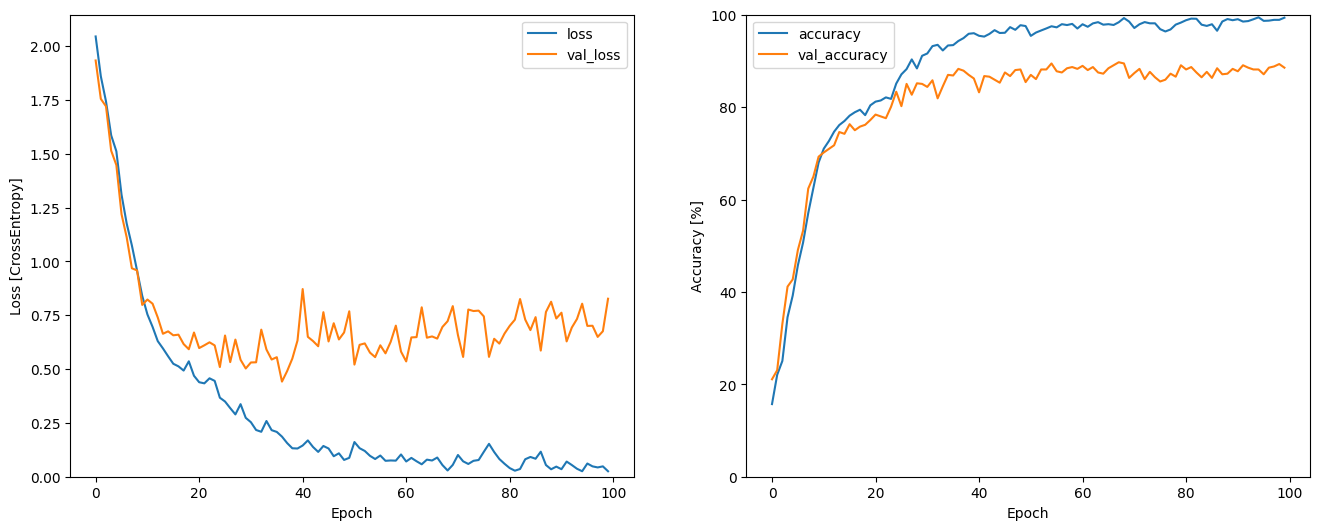

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [23]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 6s 243ms/step - loss: 0.9396 - accuracy: 0.8714


{'loss': 0.9395691752433777, 'accuracy': 0.8713942170143127}

### Display a confusion matrix


In [24]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 2s 56ms/step


In [25]:
y_pred = tf.argmax(y_pred, axis=1)

In [26]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

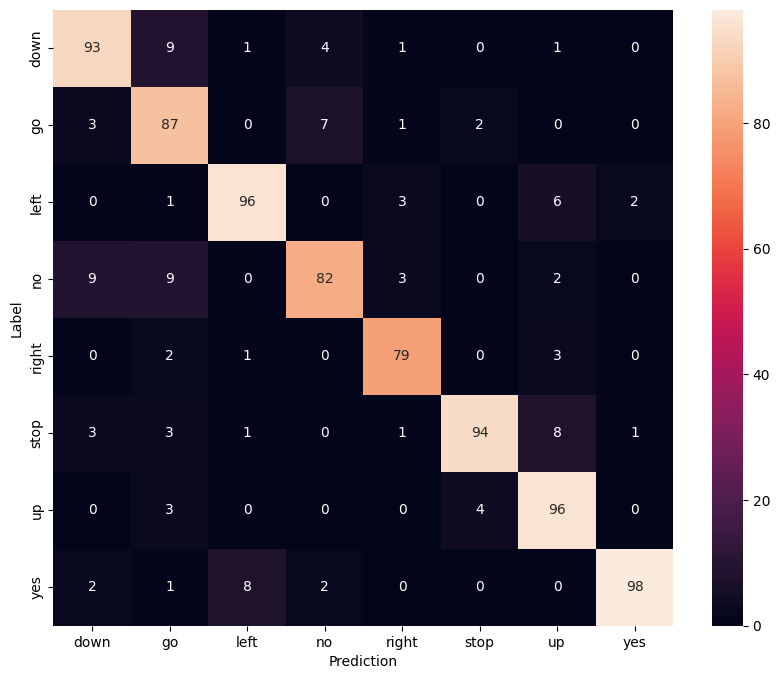

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### Performance metrics

In [28]:
# Accuracy
m = tf.keras.metrics.Accuracy()

m.update_state(y_true, y_pred)

print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.8713942170143127


In [29]:
# Precision, recall and F1-score
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8455    0.8532    0.8493       109
           1     0.7565    0.8700    0.8093       100
           2     0.8972    0.8889    0.8930       108
           3     0.8632    0.7810    0.8200       105
           4     0.8977    0.9294    0.9133        85
           5     0.9400    0.8468    0.8910       111
           6     0.8276    0.9320    0.8767       103
           7     0.9703    0.8829    0.9245       111

    accuracy                         0.8714       832
   macro avg     0.8747    0.8730    0.8721       832
weighted avg     0.8761    0.8714    0.8720       832



### RNN

In [30]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

rnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    norm_layer,
    layers.SimpleRNN(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_labels),
])

rnn_model.summary()

Input shape: (124, 129)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 124, 129)         259       
 ion)                                                            
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               98816     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                              

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [31]:
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [32]:
EPOCHS = 100

rnn_history = rnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/100
100/100 [==============================] - 12s 84ms/step - loss: 2.0906 - accuracy: 0.1275 - val_loss: 2.0772 - val_accuracy: 0.1393
Epoch 2/100
100/100 [==============================] - 8s 80ms/step - loss: 2.0801 - accuracy: 0.1350 - val_loss: 2.0755 - val_accuracy: 0.1419
Epoch 3/100
100/100 [==============================] - 8s 82ms/step - loss: 2.0750 - accuracy: 0.1483 - val_loss: 2.0728 - val_accuracy: 0.1419
Epoch 4/100
100/100 [==============================] - 8s 82ms/step - loss: 2.0613 - accuracy: 0.1477 - val_loss: 2.0770 - val_accuracy: 0.1250
Epoch 5/100
100/100 [==============================] - 8s 80ms/step - loss: 2.0468 - accuracy: 0.1686 - val_loss: 2.0566 - val_accuracy: 0.1667
Epoch 6/100
100/100 [==============================] - 8s 79ms/step - loss: 2.0405 - accuracy: 0.1808 - val_loss: 2.0830 - val_accuracy: 0.1263
Epoch 7/100
100/100 [==============================] - 7s 66ms/step - loss: 2.0525 - accuracy: 0.1602 - val_loss: 2.0748 - val_accuracy

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

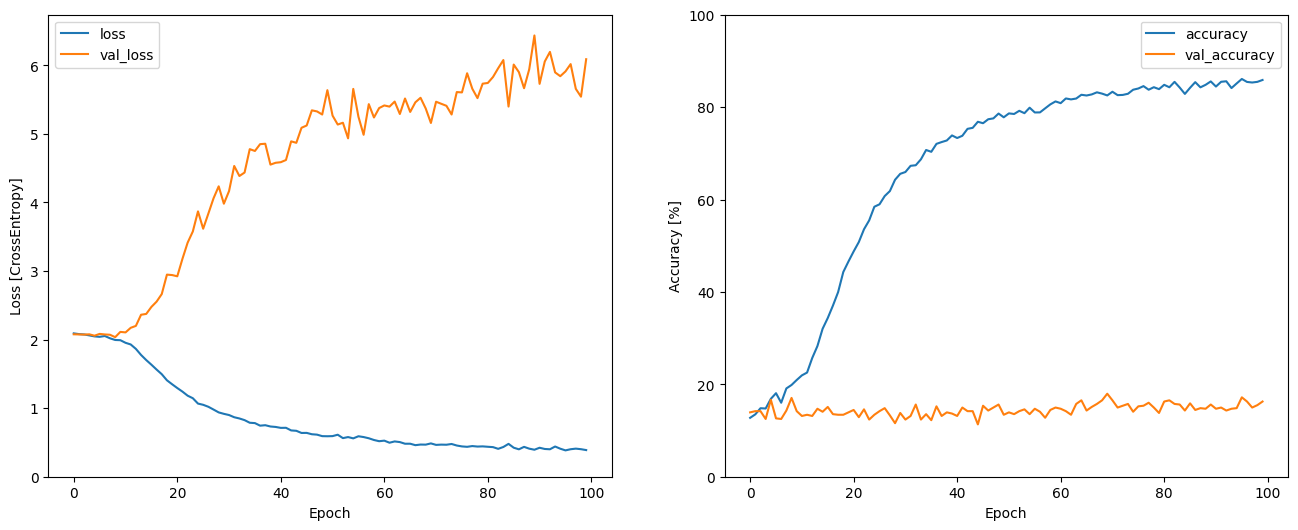

In [33]:
rnn_metrics = rnn_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(rnn_history.epoch, rnn_metrics['loss'], rnn_metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(rnn_history.epoch, 100*np.array(rnn_metrics['accuracy']), 100*np.array(rnn_metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [34]:
rnn_model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 33ms/step - loss: 6.0702 - accuracy: 0.1575


{'loss': 6.070210933685303, 'accuracy': 0.15745192766189575}

### Display a confusion matrix


In [35]:
rnn_y_pred = rnn_model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 34ms/step


In [36]:
rnn_y_pred = tf.argmax(rnn_y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

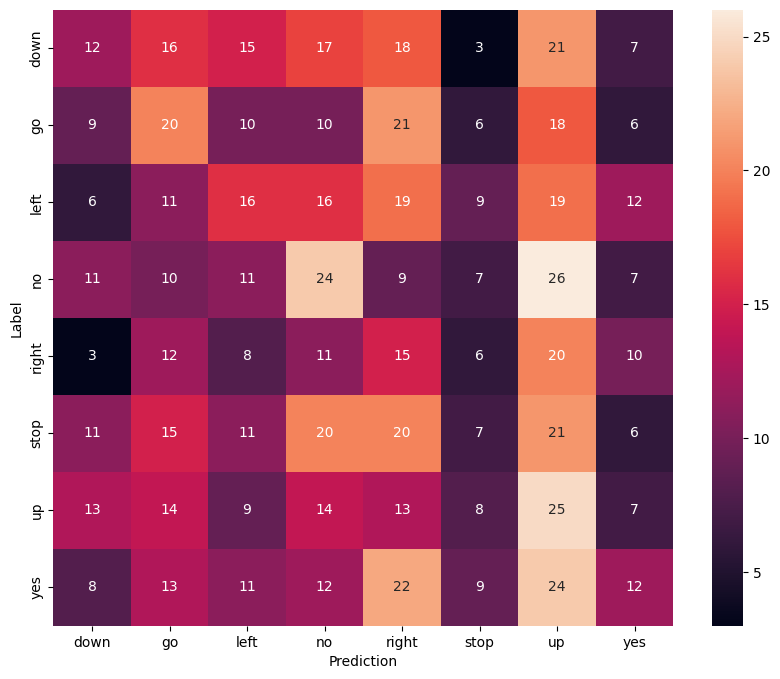

In [38]:
rnn_confusion_mtx = tf.math.confusion_matrix(y_true, rnn_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(rnn_confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### Performance metric

In [39]:
# Accuracy
m = tf.keras.metrics.Accuracy()

m.update_state(y_true, rnn_y_pred)

print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.15745192766189575


In [40]:
# Precision, recall and F1-score
print(classification_report(y_true, rnn_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.1644    0.1101    0.1319       109
           1     0.1802    0.2000    0.1896       100
           2     0.1758    0.1481    0.1608       108
           3     0.1935    0.2286    0.2096       105
           4     0.1095    0.1765    0.1351        85
           5     0.1273    0.0631    0.0843       111
           6     0.1437    0.2427    0.1805       103
           7     0.1791    0.1081    0.1348       111

    accuracy                         0.1575       832
   macro avg     0.1592    0.1596    0.1533       832
weighted avg     0.1603    0.1575    0.1528       832

